#### Multi-level interventions
Intsem models have the provision of intevening at multiple levels. We can choose the level of abstraction to intervene on based on the severity of the misclassification. 

In [1]:
import sys
# add to sys.path to import from parent directory
sys.path.append("..")

In [2]:
import torch
from model import InterpretableResnet2
from processing import utils
from dataloader import Awa2ClassLevelDataset, ImagenetMultiClassLevelsDataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import json
import numpy as np

/raid/ai22resch11001/anaconda3/envs/fca/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
weights_path = "./fca4nn/fca4nn/saved_models/imagenet100/3intsem/exp_2025:05:13-19:19:43/intsem_3_level_50_0.8449.pt"
lattice_path = "./fca4nn/data/lattices/imagenet_reduced_attr2_context.pkl"
data_root ="./data/inet100"
concept_file = "./data/inet100/imagenet_reduced_attr2.json"
weights = torch.load(weights_path, map_location="cpu", weights_only=True)
lattice_levels = [1, 5, 7]
backbone_layer_ids = [2, 3, 4]
num_classes = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
perlevel_intents, perlevel_fcs = utils.get_info_from_lattice(lattice_path, lattice_levels)
ind_to_attr1, ind_to_attr2 = dict(enumerate(perlevel_intents[1])), dict(enumerate(perlevel_intents[2]))
attr1_to_ind, attr2_to_ind = {v: k for k, v in ind_to_attr1.items()}, {v: k for k, v in ind_to_attr2.items()}

perlevel_intents[0] = np.array(perlevel_intents[0])
perlevel_intents[1] = np.array(perlevel_intents[1])

test_dataset = ImagenetMultiClassLevelsDataset(
    data_root=data_root,
    json_file=concept_file,
    split="test",
    lattice_levels=lattice_levels,
    lattice_path=lattice_path,
    perlevel_intents=perlevel_intents,
    perlevel_fcs=perlevel_fcs,
)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=2, drop_last=False, shuffle=False)

In [5]:
model = InterpretableResnet2(perlevel_intents, perlevel_fcs, backbone_layer_ids, num_classes, pretrained_clfs=False, backbone_name="resnet50")
model.load_state_dict(weights, strict=True)

<All keys matched successfully>

In [6]:
# Choose a test image and get the attribute activations at multiple layers
_, img, cls, attrs_present, classes_present = next(iter(test_loader))

In [7]:
get_class = test_dataset.class_label_map
get_class[cls[0].item()]

'n01498041'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


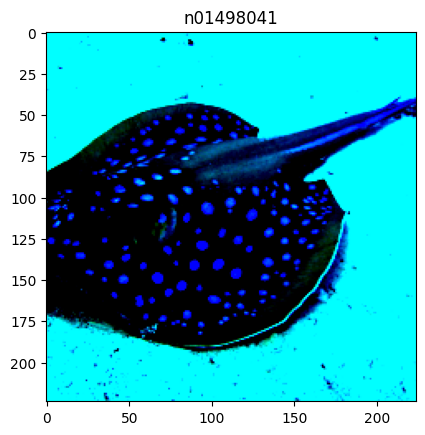

In [8]:
# Display the image
import matplotlib.pyplot as plt
plt.imshow(img[0].permute(1, 2, 0))
plt.title(get_class[cls[0].item()])
plt.show()

In [9]:
img = img.to('cuda')
cls = cls.to('cuda')
model.to('cuda')

attr_preds, class_preds = model(img)

In [10]:
# Batch size is 256. So attr_preds contains 2 elements of shape 256 x attr_layer_size
attr_preds[0].shape, attr_preds[1].shape, attr_preds[2].shape

(torch.Size([256, 25]), torch.Size([256, 64]), torch.Size([256, 700]))

In [11]:
# Firstly, do they make sense?
print(attr_preds[0][0])       # Attribute activations at layer 1 for the first image
print(attrs_present[0][0])    # Attributes present in the first image

tensor([0.3426, 0.4980, 0.7030, 0.2178, 0.3501, 0.3291, 0.4470, 0.1678, 0.3260,
        0.5861, 0.3278, 0.2640, 0.2262, 0.3109, 0.3104, 0.2833, 0.6639, 0.3660,
        0.4538, 0.5375, 0.5500, 0.6509, 0.4002, 0.2306, 0.6324],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1.], dtype=torch.float64)


They look pretty aligned

In [12]:
print("Predicted attributes in l1: ", perlevel_intents[0][attr_preds[0][0].cpu() > 0.5])
print("GT attributes in l1: ", perlevel_intents[0][attrs_present[0][0].cpu() == 1])

Predicted attributes in l1:  ['a fish' 'a net' 'animal' 'rocks' 'sand' 'seaweed' 'vertebrate']
GT attributes in l1:  ['a animal' 'a fish' 'a net' 'sand' 'vertebrate']


In [13]:
print(attr_preds[1][0])        # Attribute activations at layer 2 for the first image
print(attrs_present[1][0])     # Attributes present in the first image

tensor([0.3258, 0.1373, 0.1768, 0.1288, 0.1874, 0.4140, 0.1733, 0.7424, 0.1751,
        0.5151, 0.0929, 0.2845, 0.2272, 0.2589, 0.2245, 0.4306, 0.3240, 0.1872,
        0.1287, 0.4665, 0.4987, 0.2316, 0.3352, 0.3720, 0.1589, 0.5965, 0.1366,
        0.0901, 0.4146, 0.3521, 0.1350, 0.4031, 0.2391, 0.1070, 0.0935, 0.1667,
        0.0981, 0.2799, 0.2024, 0.3220, 0.1193, 0.7892, 0.2010, 0.4593, 0.1616,
        0.2698, 0.6662, 0.1531, 0.2532, 0.4139, 0.1680, 0.6347, 0.1160, 0.2458,
        0.4012, 0.2072, 0.4035, 0.3443, 0.5386, 0.4268, 0.1606, 0.3936, 0.2006,
        0.6061], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], dtype=torch.float64)


In [14]:
print("Predicted attributes in l1: ", perlevel_intents[1][attr_preds[1][0].cpu() > 0.5])
print("GT attributes in l1: ", perlevel_intents[1][attrs_present[1][0].cpu() == 1])

Predicted attributes in l1:  ['a fish' 'a human' 'a net' 'a water' 'animal' 'fish' 'sand' 'vertebrate']
GT attributes in l1:  ['a animal' 'a fish' 'a human' 'a net' 'sand' 'vertebrate']


In [15]:
# Now lets do some interventions
# First get misclassifications
misclfs = []
for i in range(256):
    if torch.argmax(class_preds[2][i].softmax(dim=-1)) != cls[i]:
        misclfs.append([i, cls[i].item(), torch.argmax(class_preds[2][i].softmax(dim=-1)).item()])
        print("Misclassification at sample: ", i)
        print("GT: ", cls[i].item())
        print("Predicted: ", torch.argmax(class_preds[2][i].softmax(dim=-1)).item())     

Misclassification at sample:  7
GT:  93
Predicted:  16
Misclassification at sample:  10
GT:  30
Predicted:  70
Misclassification at sample:  12
GT:  21
Predicted:  53
Misclassification at sample:  16
GT:  96
Predicted:  43
Misclassification at sample:  17
GT:  6
Predicted:  43
Misclassification at sample:  26
GT:  95
Predicted:  51
Misclassification at sample:  30
GT:  74
Predicted:  72
Misclassification at sample:  39
GT:  47
Predicted:  82
Misclassification at sample:  90
GT:  94
Predicted:  4
Misclassification at sample:  93
GT:  32
Predicted:  11
Misclassification at sample:  99
GT:  64
Predicted:  72
Misclassification at sample:  101
GT:  51
Predicted:  95
Misclassification at sample:  112
GT:  86
Predicted:  91
Misclassification at sample:  113
GT:  48
Predicted:  55
Misclassification at sample:  154
GT:  95
Predicted:  82
Misclassification at sample:  156
GT:  51
Predicted:  95
Misclassification at sample:  158
GT:  7
Predicted:  42
Misclassification at sample:  161
GT:  17
Pred

In [16]:
level = -2

In [17]:
# Check at the first level at which the misclassification happens (l0 -> ln)
i = 0
while level > -4:
    ind, gt, predicted = misclfs[i]
    print(i)
    gt_group = torch.nonzero(classes_present[level][ind] == 1, as_tuple=True)[0]
    if predicted in gt_group:
        print("In group")
    else:
        print("Not in group")
        break
    i += 1
    if i >= len(misclfs):
        break         

0
Not in group


In [31]:
level = -2

In [32]:
# Do 10 random interventions (replace the attributes with their ground truths)
random_interventions_l1 = np.random.choice(len(attr_preds[level][ind]), 20, replace=False)
random_interventions_l1

random_interventions_l2 = [attr2_to_ind[i] for i in [ind_to_attr1[int(j)] for j in random_interventions_l1]]

In [33]:
attrs_present = [i.cuda() for i in attrs_present]

In [34]:
attr_pred1 = attr_preds[level][ind].clone()
mini, maxi = attr_preds[level].min(), attr_preds[level].max()
# ep = 1e-6
soft_attrs_present = attrs_present[level] * (maxi) + (1 - attrs_present[level]) * mini
attr_pred1[random_interventions_l1] = soft_attrs_present[ind][random_interventions_l1].float()

In [35]:
level += 1

In [36]:
attr_pred2 = attr_preds[level][ind].clone()
mini, maxi = attr_preds[level].min(), attr_preds[level].max()
# ep = 1e-6
soft_attrs_present = attrs_present[level] * (maxi) + (1 - attrs_present[level]) * mini
attr_pred2[random_interventions_l2] = soft_attrs_present[ind][random_interventions_l2].float()

In [37]:
# unsigmoid
attr_pred1[random_interventions_l1] = torch.log(attr_pred1[random_interventions_l1] / (1 - attr_pred1[random_interventions_l1]))
attr_pred2[random_interventions_l2] = torch.log(attr_pred2[random_interventions_l2] / (1 - attr_pred2[random_interventions_l2]))


In [38]:
attr_pred1

tensor([ 0.5673,  0.4268,  0.2973, -6.2051, -6.2051,  0.2634, -6.2051,  0.2703,
         0.2706,  0.3272,  0.3883,  0.2815,  0.2581,  0.3849, -6.2051,  0.1876,
         0.1386, -6.2051,  0.1350,  0.1773, -6.2051, -6.2051,  0.4530,  0.3478,
        -6.2051,  0.4578,  0.2538,  0.6224, -6.2051,  0.3556,  0.3981, -6.2051,
        -6.2051,  0.5846,  0.1116,  0.2306,  0.1073, -6.2051,  0.2423, -6.2051,
         0.3333,  0.4010, -6.2051,  0.5361,  0.2199,  0.2588, -6.2051,  0.1542,
        -6.2051,  0.3135,  0.2922,  0.3392, -6.2051, -6.2051,  0.2600, -6.2051,
         0.7009,  0.5930,  0.3887,  0.4243,  0.4340,  0.2721,  0.3721,  9.1007],
       device='cuda:0', grad_fn=<IndexPutBackward0>)

In [39]:
level -= 1

In [40]:
# Do this lead a correction in the current level?
new_class_preds = [0] * (-1 * level)
new_class_preds[level] = model.classifier_layers[level](attr_pred1.cuda())
new_class_preds[level+1] = model.classifier_layers[level+1](attr_pred2.cuda())

In [41]:
class_preds[level][ind].sigmoid()

tensor([0.0929, 0.2173, 0.1182, 0.1063, 0.4416, 0.2514, 0.9786, 0.0904, 0.4370,
        0.2281, 0.6110, 0.0414, 0.6261, 0.9169, 0.2636, 0.3382, 0.8789, 0.7660,
        0.0529, 0.0944, 0.7038, 0.3891, 0.0136, 0.3343, 0.3614, 0.2250, 0.3273,
        0.9279, 0.1398, 0.2962, 0.2769, 0.9927, 0.0532, 0.4741, 0.2781, 0.4179,
        0.1869, 0.0682, 0.4306, 0.3580, 0.4598, 0.6847, 0.1789, 0.5120, 0.1723,
        0.4295, 0.3630, 0.0912, 0.1877, 0.4023, 0.8504, 0.2485, 0.1886, 0.2034,
        0.2166, 0.1858, 0.2984, 0.4350, 0.3124, 0.0967, 0.2306, 0.1758, 0.0677,
        0.8538, 0.8173, 0.3468, 0.3342, 0.0294, 0.8170, 0.9688, 0.4184, 0.3018,
        0.1364, 0.2680, 0.2267, 0.0026, 0.7183, 0.7113, 0.9530, 0.1603, 0.0843,
        0.0042, 0.4055, 0.7957, 0.3037, 0.8266, 0.0403, 0.2302, 0.0283, 0.3771,
        0.3315, 0.1658, 0.2834, 0.3101, 0.1514, 0.0441, 0.9501, 0.1611, 0.5975,
        0.1933], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [42]:
new_class_preds[level].sigmoid()

tensor([2.1055e-01, 4.4969e-10, 9.0244e-02, 1.6754e-01, 3.7117e-05, 5.3971e-17,
        9.5022e-01, 2.9546e-02, 6.5754e-02, 1.4426e-01, 9.9953e-01, 3.6146e-01,
        1.5169e-04, 2.9610e-03, 1.1013e-04, 5.3618e-01, 2.9407e-06, 5.9783e-01,
        9.0173e-05, 5.9417e-04, 9.9873e-01, 5.3051e-01, 9.8486e-01, 5.8039e-08,
        1.0951e-05, 2.1869e-04, 1.4650e-04, 4.8965e-01, 9.9135e-01, 9.9923e-01,
        1.1121e-12, 2.0657e-01, 9.9975e-14, 9.7389e-01, 1.7024e-07, 9.9449e-01,
        7.5229e-04, 9.9995e-01, 2.0865e-06, 9.8828e-05, 5.6876e-04, 5.3316e-02,
        1.8568e-05, 1.0112e-07, 4.1483e-02, 9.5039e-01, 2.7331e-13, 1.6319e-13,
        1.8771e-08, 8.3573e-02, 1.2144e-02, 4.5937e-08, 2.5255e-11, 9.9353e-01,
        3.3990e-09, 3.2383e-12, 9.9961e-01, 1.2187e-01, 9.5290e-01, 9.9958e-01,
        1.9926e-05, 9.8713e-01, 8.2028e-01, 4.1121e-03, 2.1511e-05, 1.1050e-08,
        2.8621e-06, 6.6203e-02, 1.0000e+00, 9.8918e-01, 3.9352e-03, 1.0000e+00,
        9.9733e-01, 4.5355e-05, 1.0000e+

In [43]:
level

-2

In [44]:
# In subsequent levels?
while level < -1:
    level += 1
    new_class_preds[level] = new_class_preds[level - 1].sigmoid() * new_class_preds[level]


In [96]:
new_class_preds[level].shape

torch.Size([100])

In [45]:
torch.argmax(new_class_preds[-1].softmax(dim=-1), dim=-1), gt

(tensor(93, device='cuda:0'), 93)

In [77]:
gt in torch.nonzero(new_class_preds[-2].sigmoid() > 0.5, as_tuple=True)[0]

True

In [56]:
new_class_preds[-1].softmax(dim=-1)

tensor([3.4407e-04, 5.7463e-03, 1.1002e-02, 3.1274e-04, 2.4904e-07, 3.2567e-04,
        1.8771e-02, 5.9056e-03, 5.0862e-07, 4.5048e-03, 1.0952e-02, 4.4791e-05,
        1.6334e-03, 5.7722e-03, 7.6351e-03, 2.7218e-02, 4.5167e-07, 2.6236e-02,
        5.7128e-06, 1.0783e-03, 3.1268e-04, 2.4091e-06, 8.6055e-03, 3.3129e-04,
        1.4272e-03, 3.1274e-04, 3.9078e-04, 2.0200e-03, 5.4542e-02, 3.9474e-04,
        8.5757e-03, 1.8191e-02, 3.3098e-04, 8.4452e-03, 5.2949e-03, 3.9776e-04,
        3.1267e-04, 1.0995e-02, 5.9764e-02, 9.9662e-03, 1.3733e-02, 1.5408e-01,
        1.7144e-07, 2.0635e-02, 1.5638e-01, 1.4704e-07, 5.6144e-03, 4.7647e-04,
        3.4742e-04, 2.0784e-04, 2.4872e-02, 3.1267e-04, 1.2971e-07, 5.1857e-06,
        7.6494e-03, 3.1333e-04, 3.2361e-04, 1.0448e-02, 1.0857e-02, 1.2136e-02,
        3.7908e-04, 3.3884e-04, 3.3532e-04, 2.8152e-02, 7.1951e-05, 8.2631e-03,
        1.3839e-02, 5.3977e-04, 6.4487e-04, 4.6317e-04, 1.3553e-02, 3.2839e-04,
        1.3502e-03, 5.9663e-03, 8.2644e-